In [27]:
import numpy as np
from scipy.stats import truncnorm
import warnings

class DMC:
    def __init__(
        self,
        prior_means: np.ndarray,
        prior_sds: np.ndarray,
        param_names: tuple[str] = ('A', 'tau', 'mu_c', 'mu_r', 'b'),
        param_lower_bound: float | None = 0,
        fixed_num_obs: float | None = 200,
        tmax: int = 1200,
        dt: float = 1,
        sigma: float = 4.0,
        X0_beta_shape_fixed: int = 3,
        sdr_fixed: float | None = 0,
        a_value: int = 2,
        num_conditions: int = 2,
        contamination_probability: float | None = None,
        contamination_uniform_lower: float = 0,
        contamination_uniform_upper: float = 2,
        min_num_obs: int = 50,
        max_num_obs: int = 800,
    ):
        """
        Initialize the DMC simulator ina  BayesFlow-friendly format.

        Parameters
        ----------
        prior_means : np.ndarray
            Array of prior means for the model parameters. 
        prior_sds : np.ndarray
            Array of prior standard deviations for the model parameters.
        param_names : tuple of str, optional
            Names of the parameters. Default is ('A', 'tau', 'mu_c', 'mu_r', 'b', 'sd_r').
        param_lower_bound : float or None, optional
            Lower bound for the prior.
        fixed_num_obs : float, optional
            Number of simulated trials. Default is 200. Set to None and specify minimal number of observations (min_num_obs) and
            maximum number of observations (max_num_obs) to include random sampling of trial numbers.
        min_num_obs:
            Lower boundary of uniform distribution used to randomly sample trials numbers. Only applied if fixed_num_obs is not None.
        max_num_obs:
            Upper boundary of uniform distribution used to randomly sample trials numbers. Only applied if fixed_num_obs is not None.
        tmax : int, optional
            Maximum simulation time in milliseconds. Default is 1200.
        dt : float, optional
            Time step of the simulation. Default is 1.
        sigma : floaFixed value for trial-to-trial variability in non-decision time.
            If None, the non-decision time is drawn from a normal distribution with standard deviation sdr drawn from specified prior distributions.t, optional
            Standard deviation of the noise in the diffusion process. Default is 4.0.
        X0_beta_shape_fixed : int, optional
            Shape parameter used for beta distribution of initial states. Default is 3.
        sdr_fixed: float, None
            Fixed value for trial-to-trial variability in non-decision time.
            If None, the non-decision time is sampled from a normal distribution with standard deviation sdr, which is itself drawn from the specified prior distribution.
        a_value : int, optional
            Constant 'a' value used in the simulation. Default is 2. a > 1 is a necessary condition to simulate data.
        num_conditions : int, optional
            The number of conditions in the experiment. Default is 2.
        contamination_probability :
            Rate of contamination during robust training. 
        contamination_uniform_lower:
            lower bound of random RTs used in robust training.
        contamination_uniform_upper:
            upper bound of random RTs used in robust training.
        """

        self.fixed_num_obs = fixed_num_obs
        self.tmax = tmax
        self.dt = dt
        self.sigma = sigma
        self.param_names = param_names
        self.param_lower_bound = param_lower_bound
        self.prior_means = prior_means
        self.prior_sds = prior_sds
        self.X0_beta_shape_fixed = X0_beta_shape_fixed
        self.a_value = a_value
        self.num_conditions = num_conditions
        self.contamination_probability = contamination_probability
        self.contamination_uniform_lower = contamination_uniform_lower
        self.contamination_uniform_upper = contamination_uniform_upper
        self.min_num_obs = min_num_obs
        self.max_num_obs = max_num_obs
        self.sdr_fixed = sdr_fixed

        if prior_means.shape[0] <= 4 or prior_sds.shape[0]<= 4:

            raise ValueError(f"Only {prior_means.shape[0]} prior means and {prior_sds.shape[0]} prior sds are provided. Specify prior means and sds for each parameter.")
        
        if self.a_value <= 1:

            raise ValueError(f"a (gamma shape) = {a_value}. Please choose a value larger than 1.")
        

        if prior_means.shape[0] != len(param_names):

            raise ValueError(f'Number of prior means ({prior_means.shape[0]}) does not match the number of parameter names ({len(param_names)}).')
        

        if prior_sds.shape[0] != len(param_names):

            raise ValueError(f'Number of prior sds ({prior_means.shape[0]}) does not match the number of parameter names ({len(param_names)}).')
        

        if self.sdr_fixed is None:
            if self.prior_means.shape[0] <= 5 or self.prior_sds.shape[0] <= 5:
                
                raise ValueError("sdr_fixed = None but no prior parameters have been provided. choose a fixed value for sdr_foxed or specify prior_mean and prior_sds for sdr to include trial-to-trial variability of the non-decision time")
            

        if self.sdr_fixed is not None:
            if self.prior_means.shape[0] > 5 or self.prior_sds.shape[0] > 5:

                warnings.warn(
                        f"sdr_fixed = {self.sdr_fixed}, but six prior parameters were provided. "
                        "The prior mean and standard deviation for sdr will be ignored, and the fixed value will be used instead. "
                        "To simulate trial-to-trial variability, set sdr_fixed = None.",
                        UserWarning
                    )
                

        if num_conditions != 2:
            raise ValueError("Number of conditions must be 2 for this experiment.")
        
        if prior_means.shape[0] != prior_sds.shape[0]:

            raise ValueError("prior_mean and prior_sds do not have the same shape. Specify mean and sd for each parameter.")
            


    def prior(self):
        """
        Sample from a (possibly truncated) normal distribution using prior parameters.
    
        Returns
        -------
        out : np.ndarray
            Sampled values from the (possibly truncated) normal distribution.
        """

        if self.param_lower_bound is not None:
            a = (self.param_lower_bound - self.prior_means) / self.prior_sds
            b = (np.inf - self.prior_means) / self.prior_sds
            p = truncnorm.rvs(a, b, loc=self.prior_means, scale=self.prior_sds)

                # set sd_r to fixed value if specified
            if self.sdr_fixed is not None:

                return dict(A=p[0], tau=p[1], mu_c=p[2], mu_r=p[3], b=p[4])

            else:

                return dict(A=p[0], tau=p[1], mu_c=p[2], mu_r=p[3],sd_r=p[-1], b=p[4])

        return np.random.normal(self.prior_means, self.prior_sds)

    def trial(self, A: float, tau: float, mu_c: float, b: float, t: np.ndarray, noise: np.ndarray, non_decision_ts: np.ndarray):
        """
        Simulate multiple DMC trials in parallel.

        Parameters
        ----------
        A : float
            Amplitude of the control signal.
        tau : float
            Time constant for exponential decay.
        mu_c : float
            Constant drift component.
        mu_r : float
            mean of the non-decision time (in ms).
        b : float
            Decision boundary.
        t : np.ndarray
            Time array (in ms), shape (T,)
        noise : np.ndarray
            Noise samples, shape (n_trials, T)

        Returns
        -------
        rts : np.ndarray
            Response times in seconds, shape (n_trials,). -1 if no response.
        resps : np.ndarray
            Responses (1 = correct, 0 = error, -1 = no response), shape (n_trials,)
        """

        num_trials, _ = noise.shape
        dt = self.dt
        sqrt_dt_sigma = self.sigma * np.sqrt(dt)

        # Initial positions X0 for all trials
        X0 = np.random.beta(self.X0_beta_shape_fixed, self.X0_beta_shape_fixed, size=num_trials) * (2 * b) - b

        # Drift term mu(t), shape (T,)
        t_div_tau = t / tau
        exponent_term = np.exp(-t_div_tau)
        power_term = (np.exp(1) * t_div_tau / (self.a_value - 1)) ** (self.a_value - 1)
        deriv_term = ((self.a_value - 1) / t) - (1 / tau)
        mu_t = A * exponent_term * power_term * deriv_term + mu_c  # shape (T,)

        # Full drift for all trials: broadcast mu_t to (n_trials, T)
        dX = mu_t[None, :] * dt + sqrt_dt_sigma * noise  # shape (n_trials, T)
        X_shift = np.cumsum(dX, axis=1) + X0[:, None]    # shape (n_trials, T)

        # Check boundary crossings
        crossed_upper = X_shift >= b
        crossed_lower = X_shift <= -b
        crossed_any = crossed_upper | crossed_lower

        # First crossing index for each trial
        first_crossing = np.argmax(crossed_any, axis=1)
        has_crossed = np.any(crossed_any, axis=1)

        # Prepare output
        rts = np.full(num_trials, -1.0)
        resps = np.full(num_trials, -1)

        # Fill only for trials that crossed
        idx = np.where(has_crossed)[0]
        crossing_times = t[first_crossing[idx]]

        # use nondecision times only for trials that crossed
        non_decision_ts_crossed = non_decision_ts[idx]

        rts[idx] = (crossing_times + non_decision_ts_crossed) / 1000  # convert to seconds

        # Determine response type
        resp_hit = X_shift[idx, first_crossing[idx]]
        resps[idx] = (resp_hit >= b).astype(int)

        return np.c_[rts, resps]
    
    def experiment(
        self, 
        A: float, 
        tau: float, 
        mu_c: float, 
        mu_r: float, 
        b: float,
        num_obs: int,
        sd_r: float = 0
    ):
        """
        Simulate multiple DMC trials in parallel.

        Parameters
        ----------
        A : float
            Amplitude of the control signal.
        tau : float
            Time constant for exponential decay.
        mu_c : float
            Constant drift component.
        mu_r : float
            Mean of Non-decision time (in ms).
        b : float
            Decision boundary.
        min_num_obs : int
            The minimum number of observations if num_obs not available.
        max_num_obs : int
            The maxmimum number of observations if num_obs not available.
            

        Returns
        -------
        sims : dict
            A dictionary with three keys: data - contains a (num_obs, 2) array of
            response times and choices; conditions - contains a (num_obs, ) array
            indicating the conditions; num_obs - an int indicating the number of trials.
        """
        
        # random number of trials
        # num_obs = self.num_obs or np.random.randint(min_num_obs, max_num_obs+1)
        
        # congruency conditions (equal split)
        obs_per_condition = int(np.ceil(num_obs / self.num_conditions))
        conditions = np.repeat(np.arange(self.num_conditions), obs_per_condition)

        # precompute vector of time steps and 2D-noise
        t = np.linspace(start=self.dt, stop=self.tmax, num=int(self.tmax / self.dt))
        noise = np.random.normal(size=(num_obs, self.tmax))
        non_decision_ts = np.random.normal(size=num_obs, loc=mu_r, scale=sd_r)
        
        data = np.zeros((num_obs, 2))
        
        # simulate CONGRUENT trials (positive Amplitude A)
        data[:obs_per_condition] = self.trial(
            A=A, tau=tau, mu_c=mu_c, b=b, t=t, noise=noise[:obs_per_condition], non_decision_ts=non_decision_ts[:obs_per_condition]
        )
        
        # simulate INCONGRUENT trials (negative Amplitude A)
        data[obs_per_condition:] = self.trial(
            A=-A, tau=tau, mu_c=mu_c, b=b, t=t, noise=noise[obs_per_condition:], non_decision_ts=non_decision_ts[obs_per_condition:]
        )
        
        conditions = conditions[:num_obs]
        
        # include contamination if probability is given
        if self.contamination_probability:
            
            # compute binomial mask with given contamination probability
            binom_mask = np.random.binomial(1, p=self.contamination_probability, size=num_obs) == 1

            # replace RTs by uniform samples
            data[:,0][binom_mask] = np.random.uniform(self.contamination_uniform_lower, 
                                                      self.contamination_uniform_upper, 
                                                      size=np.sum(binom_mask))

            # replace responses by random choices
            data[:,1][binom_mask] = np.random.binomial(1, p=0.5, size=np.sum(binom_mask))

        return dict(rt=data[:, 0], accuracy=data[:, 1], conditions=conditions, num_obs=num_obs)

    def sample(self, batch_size, **kwargs) -> dict[str, np.ndarray]:
        """Runs simulated benchmark and returns `batch_size` parameter
        and observation batches

        Parameters
        ----------
        batch_shape: tuple
            Number of parameter-observation batches to simulate.

        Returns
        -------GHV-QI8
        dict[str, np.ndarray]: simulated parameters and observables
            with shapes (`batch_size`, ...)
        """

        num_obs = self.fixed_num_obs or np.random.randint(self.min_num_obs, self.max_num_obs+1)
        
        if type(batch_size) == tuple:
            batch_size = batch_size[0]

        sims = [self(num_obs) for _ in range(batch_size)]
        sims = {k: np.stack([s[k] for s in sims], axis=0) for k in sims[0].keys()}

        # Ensure everything has a trailing dimension of 1 (so its concateneable)
        sims = {k: v[..., np.newaxis] for k, v in sims.items()}
        return sims

    def __call__(self, num_obs: int | None, **kwargs):
        
        prior_draws = self.prior()
        sims = self.experiment(**(prior_draws | {'num_obs':num_obs}))
        return prior_draws | sims




In [32]:
settings = {"prior_means": np.array([16., 111., 0.5, 322., 75.]),
                                       "prior_sds": np.array([10., 47., 0.13, 40., 23.]),
                                       "tmax": 1500,
                                       "contamination_probability": None,
                                       "min_num_obs": 50,
                                       "max_num_obs": 800,
                                       "fixed_num_obs": None}

dmc_test = DMC(**settings)


settings_sdr = {"prior_means": np.array([16., 111., 0.5, 322., 75., 30]),
                                       "prior_sds": np.array([10., 47., 0.13, 40., 23., 5]),
                                       "tmax": 1500,
                                       "contamination_probability": None,
                                       "min_num_obs": 50,
                                       "max_num_obs": 800,
                                       "param_names": ('A', 'tau', 'mu_c', 'mu_r', 'b', 'sd_r'),
                                       "fixed_num_obs": None}

dmc_test_sdr = DMC(**settings_sdr)

/tmp/ipykernel_33816/3939392778.py:116: UserWarning: sdr_fixed = 0, but six prior parameters were provided. The prior mean and standard deviation for sdr will be ignored, and the fixed value will be used instead. To simulate trial-to-trial variability, set sdr_fixed = None.
  warnings.warn(


In [34]:
dmc_test_sdr.sample(100)

{'A': array([[22.7381789 ],
        [18.48367437],
        [24.92640784],
        [ 1.68598639],
        [11.47683945],
        [38.7294645 ],
        [28.77475527],
        [16.67587383],
        [22.74191785],
        [40.91668598],
        [13.7428983 ],
        [ 5.89518856],
        [15.30323252],
        [ 5.58614087],
        [10.14699534],
        [ 9.67712041],
        [21.49703268],
        [ 1.49578745],
        [12.97272159],
        [11.90241163],
        [17.69508768],
        [11.5786074 ],
        [18.43594956],
        [18.20577277],
        [22.85876965],
        [23.63358144],
        [44.64207544],
        [13.87379278],
        [20.07820035],
        [ 3.49587475],
        [ 9.61206772],
        [15.60533406],
        [ 5.25062543],
        [15.93881177],
        [14.24886443],
        [29.51356187],
        [25.57847879],
        [ 6.4450378 ],
        [42.09833654],
        [27.10404241],
        [34.03037534],
        [22.50452748],
        [30.19412906],
      

In [35]:
test_output = dmc_test_sdr.sample(100)

for k, i in test_output.items():
    print(f'{k},{i.shape}')



A,(100, 1)
tau,(100, 1)
mu_c,(100, 1)
mu_r,(100, 1)
b,(100, 1)
rt,(100, 274, 1)
accuracy,(100, 274, 1)
conditions,(100, 274, 1)
num_obs,(100, 1)


In [21]:
import pandas as pd

df = pd.DataFrame(test_output['rt'].flatten())
df['congruency'] = test_output['conditions'].flatten()

df

,0,congruency
0,0.422060,0
1,0.603060,0
2,0.398060,0
3,0.517060,0
4,0.438060,0
...,...,...
28695,0.434153,1
28696,0.430153,1
28697,0.398153,1
28698,0.449153,1


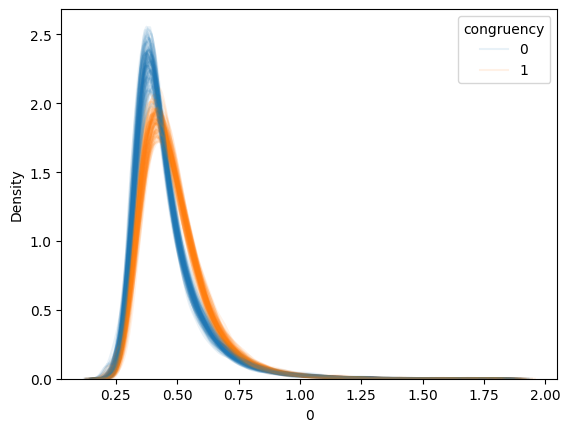

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

for i in range(0, 100):

    test_output = dmc_test_sdr.sample(100)

    df = pd.DataFrame(test_output['rt'].flatten())
    df['congruency'] = test_output['conditions'].flatten()

    df = df[df[0] != -1.0]
    sns.kdeplot(data=df, x=0, hue='congruency', alpha=0.1)

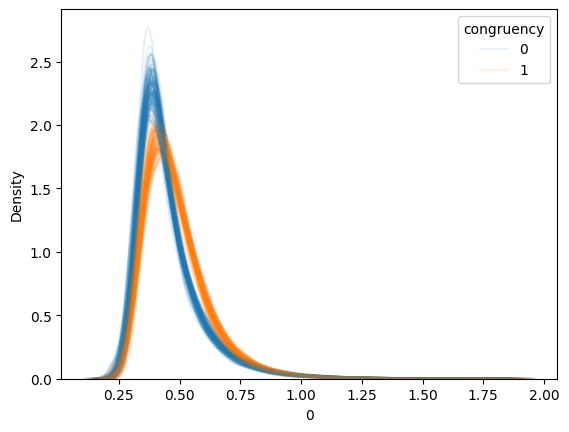

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

for i in range(0, 100):

    test_output = dmc_test.sample(100)

    df = pd.DataFrame(test_output['rt'].flatten())
    df['congruency'] = test_output['conditions'].flatten()

    df = df[df[0] != -1.0]
    sns.kdeplot(data=df, x=0, hue='congruency', alpha=0.1)